<a href="https://colab.research.google.com/github/ulfasyabania/Menyelesaikan-Permasalahan-Human-Resources/blob/main/Jaya_Jaya_Maju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## 1. Business Understanding

Pada tahap ini, mendefinisikan permasalahan bisnis yang dihadapi perusahaan *Jaya Jaya Maju*.  
Perusahaan ini mempunyai lebih dari 1.000 karyawan, namun menghadapi masalah tingginya attrition rate (lebih dari 10%).  
Tujuan proyek:
- Mengidentifikasi faktor-faktor yang mempengaruhi attrition.
- Menyusun insight untuk mendukung pengambilan keputusan oleh tim HR.
- Membangun dashboard interaktif untuk memonitor metrik kunci.

---

---

## 2. Data Understanding

- Mengimpor beberapa library
- Dataset diambil dari URL eksternal menggunakan pd.read_csv(), lalu disimpan dalam variabel df. Selanjutnya dilakukan eksplorasi awal.

---

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Membaca dataset dari URL
url = "https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/main/employee/employee_data.csv"
df = pd.read_csv(url)

# Melihat 5 baris pertama data
print("Data head:")
print(df.head())

# Informasi dan deskripsi dataset
print("\nInfo data:")
print(df.info())

print("\nSummary statistik:")
print(df.describe())

# Mengecek missing value
print("\nMissing values per column:")
print(df.isnull().sum())


Data head:
   EmployeeId  Age  Attrition     BusinessTravel  DailyRate  \
0           1   38        NaN  Travel_Frequently       1444   
1           2   37        1.0      Travel_Rarely       1141   
2           3   51        1.0      Travel_Rarely       1323   
3           4   42        0.0  Travel_Frequently        555   
4           5   40        NaN      Travel_Rarely       1194   

               Department  DistanceFromHome  Education EducationField  \
0         Human Resources                 1          4          Other   
1  Research & Development                11          2        Medical   
2  Research & Development                 4          4  Life Sciences   
3                   Sales                26          3      Marketing   
4  Research & Development                 2          4        Medical   

   EmployeeCount  ...  RelationshipSatisfaction StandardHours  \
0              1  ...                         2            80   
1              1  ...                    

Insight dari Eksplorasi Awal:

- Ada missing values di kolom Attrition, yang merupakan target prediksi. Ini perlu ditangani dengan teknik seperti penghapusan atau imputasi nilai.

- Variabel seperti Age, MonthlyIncome, dan YearsAtCompany mungkin memiliki pengaruh terhadap tingkat Attrition dan bisa digunakan untuk pemodelan.

- Beberapa kolom memiliki tipe data object yang nantinya perlu dikonversi ke numerik agar bisa digunakan dalam model.

---

---

## 3. Data Preparation

- Menghapus Baris dengan Missing Values pada Kolom 'Attrition'.
- Memastikan Kolom 'Attrition' Bertipe Numerik
- Pemilihan Fitur untuk Pemodelan
- Pemisahan Variabel Fitur (X) dan Target (y)
- Mengecek Kembali Missing Value di 'y'
- Membagi Data Menjadi Data Latih dan Data Uji

---

In [7]:
# Hapus baris yang memiliki missing value pada kolom 'Attrition'
# Mengingat bahwa nilai non-missing pada kolom Attrition sudah berupa angka, kita langsung drop baris yang kosong
df_clean = df.dropna(subset=['Attrition']).copy()

# Pastikan kolom Attrition bertipe numerik
# (jika ternyata masih berupa string, lakukan mapping, tapi dalam kasus ini seharusnya sudah numerik)
if df_clean['Attrition'].dtype == object:
    df_clean.loc[:, 'Attrition'] = df_clean['Attrition'].map({'Yes': 1, 'No': 0})
else:
    df_clean['Attrition'] = df_clean['Attrition'].astype(int)

print("Unique Attrition values:", df_clean['Attrition'].unique())
# Seharusnya menghasilkan: [0, 1]

# Definisikan beberapa fitur numerik yang diduga berpengaruh pada attrition
features = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion']

# Memisahkan variabel fitur X dan target y
X = df_clean[features]
y = df_clean['Attrition']

# Cek kembali missing pada y (seharusnya sudah 0)
print("Jumlah missing pada y:", y.isnull().sum())

# Membagi data menjadi data latih dan data uji (80:20) dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Unique Attrition values: [1 0]
Jumlah missing pada y: 0


Insight dari Persiapan Data untuk Model Attrition:
- Karena Attrition merupakan variabel target, keberadaan missing values di kolom ini bisa menyebabkan ketidakpastian dalam pelatihan model. Menghapus baris yang memiliki nilai kosong memastikan bahwa setiap observasi dalam dataset memiliki label yang valid.
- Dalam banyak kasus, data categorical seperti "Yes" dan "No" tidak dapat langsung digunakan dalam model machine learning. Mapping ke nilai 1 (Attrition) dan 0 (Tidak Attrition) memungkinkan model untuk menginterpretasikan hubungan antara variabel numerik dan kemungkinan karyawan keluar.
- Fitur yang dipilih seperti Age, MonthlyIncome, dan YearsAtCompany kemungkinan memiliki korelasi dengan tingkat keluar karyawan. Dengan memilih fitur-fitur yang lebih representatif, kita meningkatkan peluang mendapatkan model yang akurat dan interpretable.
- Pembagian dataset dengan stratifikasi memastikan bahwa proporsi antara karyawan yang keluar (Attrition=1) dan tetap bekerja (Attrition=0) tetap terjaga antara data latih dan uji. Hal ini menghindari kondisi di mana model terlalu banyak belajar dari salah satu kelas dan menjadi bias.

---

---

## 4. Exploratory Data Analysis (EDA)

---

Analisis Korelasi dan Heatmap
- Memfilter Kolom Numerik
- Menghitung Matriks Korelasi
- Visualisasi dengan Heatmap

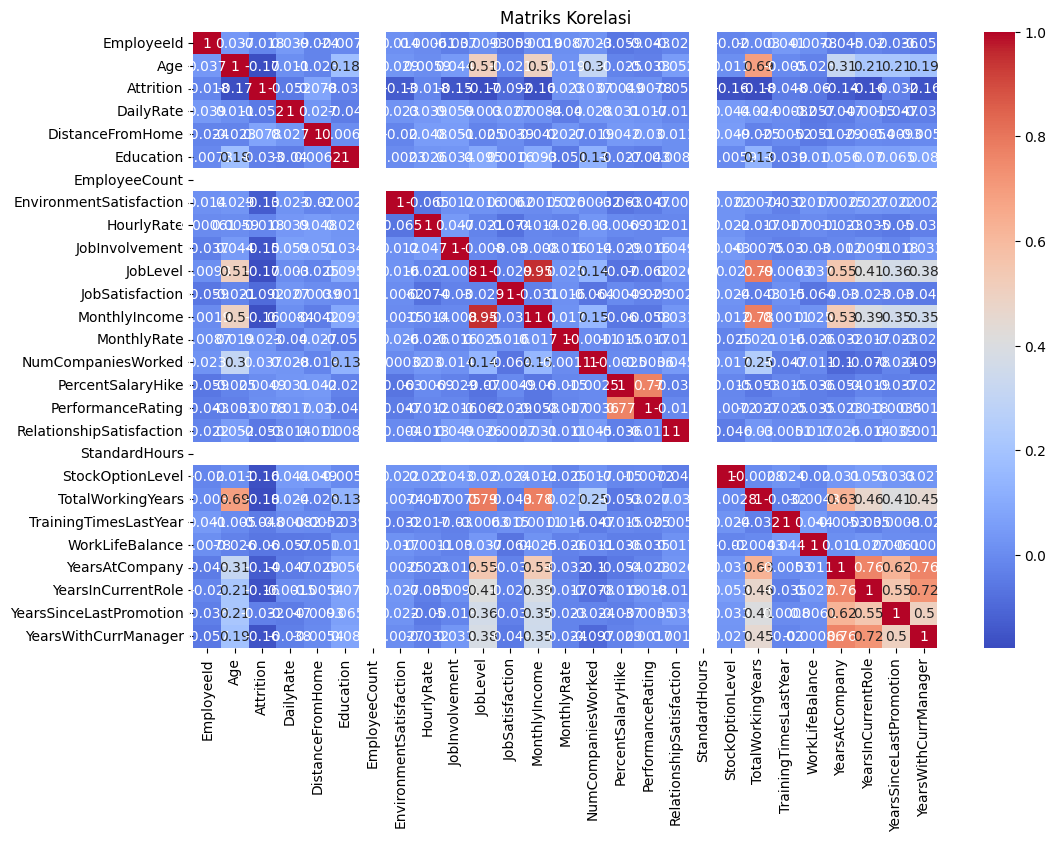

In [8]:
# Seleksi hanya kolom numerik dari DataFrame
df_numeric = df_clean.select_dtypes(include=["number"])

# Hitung matriks korelasi hanya dari kolom numerik
corr_matrix = df_numeric.corr()

# Visualisasikan dengan heatmap dari seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matriks Korelasi")
plt.show()



Insights dari Analisis Korelasi:

- Jika Attrition memiliki korelasi kuat (baik positif maupun negatif) dengan fitur tertentu, fitur tersebut bisa menjadi prediktor penting dalam model machine learning.
- Jika dua fitur memiliki korelasi sangat tinggi (>0.9), satu fitur bisa dihapus atau dikombinasikan untuk menghindari multikolinearitas dalam model.
- Analisis ini bisa mengungkap pola tak terduga. Misalnya, jika MonthlyIncome memiliki korelasi negatif dengan Attrition, mungkin karyawan dengan gaji lebih rendah lebih cenderung keluar.

---

Analisis Plot Pairwise
- Konversi 'Attrition' ke Kategori
- Pembuatan Pairplot
- Penambahan Judul

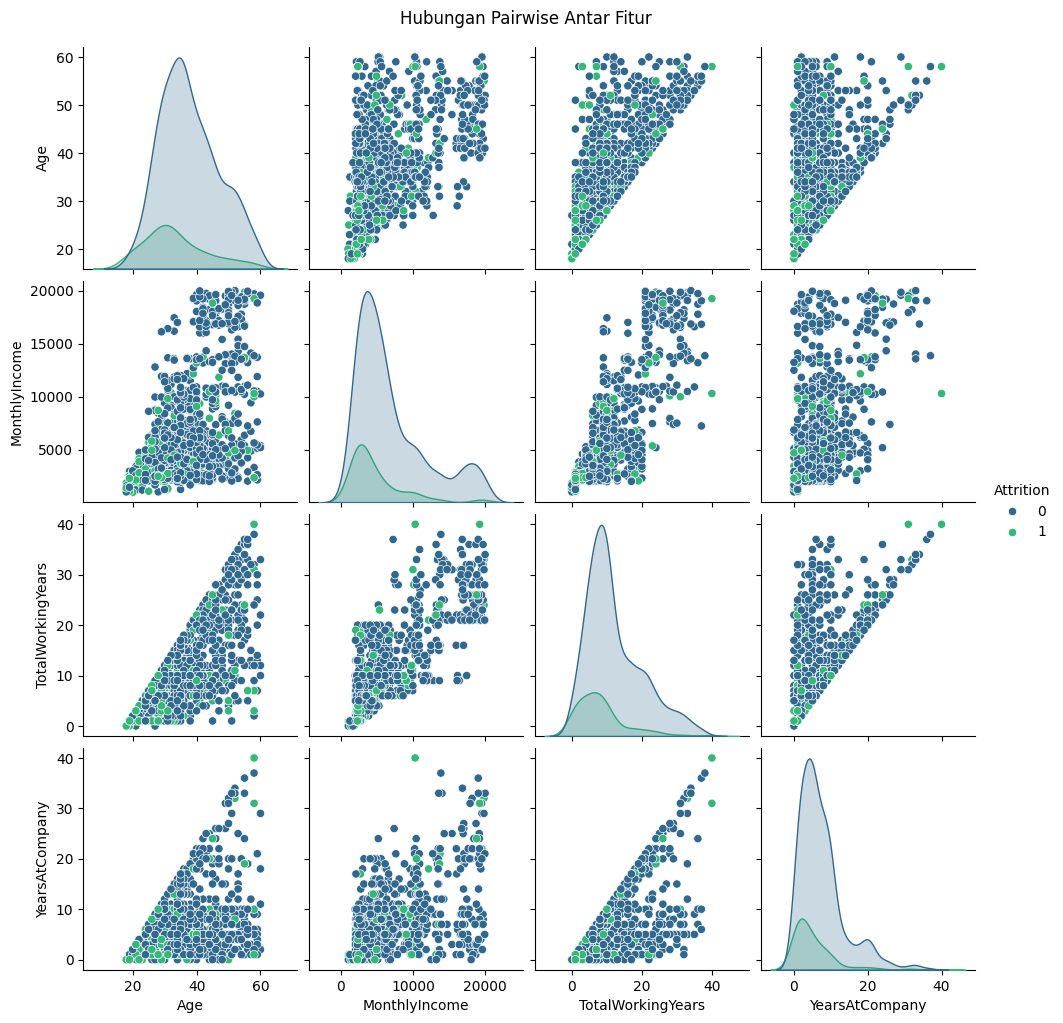

In [9]:
# Pastikan kolom 'Attrition' bertipe kategori agar seaborn dapat membedakan warnanya
df_clean['Attrition'] = df_clean['Attrition'].astype('category')

# Buat pairplot menggunakan beberapa fitur numerik dan pewarnaan berdasarkan 'Attrition'
sns.pairplot(
    df_clean,
    vars=["Age", "MonthlyIncome", "TotalWorkingYears", "YearsAtCompany"],
    hue="Attrition",
    palette="viridis"
)
plt.suptitle("Hubungan Pairwise Antar Fitur", y=1.02)
plt.show()


Insights dari Pairplot:
- Jika terlihat pola bahwa kelompok dengan Attrition=1 memiliki distribusi berbeda dari Attrition=0 dalam fitur tertentu, maka fitur tersebut bisa menjadi indikator penting dalam pemodelan.
- TotalWorkingYears vs. YearsAtCompany → Apakah karyawan dengan pengalaman lama tetap di perusahaan atau berpindah?
- MonthlyIncome vs. Age → Apakah pendapatan meningkat seiring bertambahnya usia?
- Korelasi ini bisa dianalisis lebih lanjut untuk memahami faktor utama yang memengaruhi keputusan keluar.
- Jika titik-titik data membentuk pola tertentu (misalnya garis atau cluster), itu bisa memberikan wawasan lebih jauh tentang keterkaitan fitur terhadap Attrition.

---

Histogram Distribusi Usia Berdasarkan Attrition dan Boxplot Pendapatan Bulanan Berdasarkan Attrition
- Histogram Distribusi Usia
- Boxplot Pendapatan Bulanan
- Tata Letak dan Visualisasi

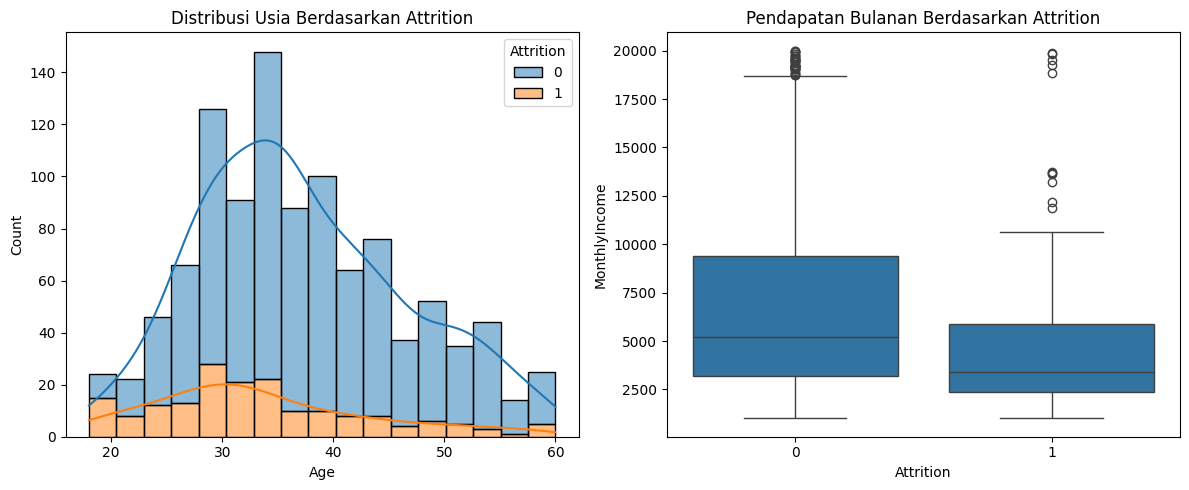

In [10]:
plt.figure(figsize=(12,5))

# Histogram distribusi usia
plt.subplot(1,2,1)
sns.histplot(data=df_clean, x="Age", hue="Attrition", kde=True, multiple="stack")
plt.title("Distribusi Usia Berdasarkan Attrition")

# Boxplot pendapatan bulanan berdasarkan Attrition
plt.subplot(1,2,2)
sns.boxplot(x="Attrition", y="MonthlyIncome", data=df_clean)
plt.title("Pendapatan Bulanan Berdasarkan Attrition")
plt.tight_layout()
plt.show()


Insights dari Visualisasi:
- Karyawan yang Keluar Lebih Banyak Berusia Muda. Jika terlihat bahwa distribusi Attrition=1 lebih terkonsentrasi di usia 20-35 tahun, ini menunjukkan bahwa karyawan muda lebih sering keluar dibandingkan yang lebih senior. Hal ini bisa menjadi indikasi kurangnya retensi terhadap karyawan baru, mungkin karena ketidakpuasan atau kurangnya peluang karier.
- Perbedaan Pendapatan Bulanan. Dari boxplot, jika Attrition=1 cenderung memiliki pendapatan lebih rendah dibandingkan Attrition=0, bisa jadi gaji merupakan faktor utama dalam keputusan keluar. Perusahaan bisa mempertimbangkan kebijakan kenaikan gaji, terutama bagi karyawan yang lebih lama bekerja agar meningkatkan loyalitas mereka.
- Distribusi Outlier. Jika ada outlier dalam pendapatan bulanan, ini bisa menunjukkan beberapa karyawan yang memiliki gaji sangat tinggi atau sangat rendah dibandingkan rata-rata.

---

Attrition Berdasarkan Departemen
- Membuat Visualisasi dengan Countplot

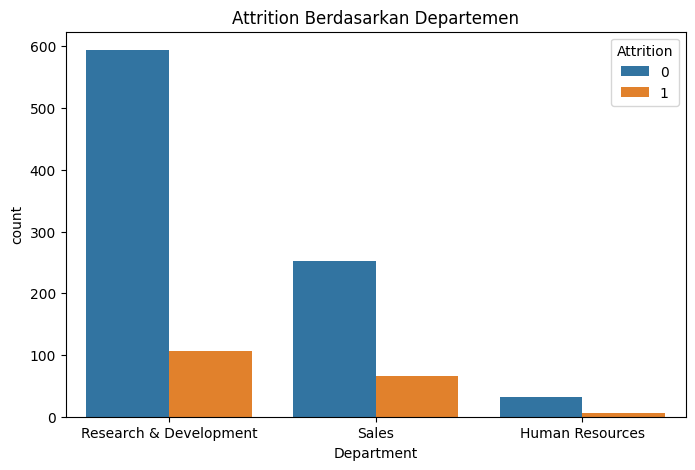

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Department", hue="Attrition", data=df_clean)
plt.title("Attrition Berdasarkan Departemen")
plt.show()


Insights dari Distribusi Attrition:
- Departemen dengan Tingkat Attrition Tertinggi. Jika salah satu departemen memiliki proporsi Attrition=1 lebih tinggi dibandingkan departemen lain, bisa jadi ada tantangan spesifik di departemen tersebut, seperti lingkungan kerja, tekanan, atau peluang karier yang lebih terbatas. Misalnya, jika departemen Sales memiliki tingkat keluar lebih tinggi, bisa jadi tekanan pencapaian target memengaruhi keputusan karyawan untuk resign.
- Departemen dengan Retensi yang Baik. Jika suatu departemen memiliki proporsi Attrition=0 lebih dominan, itu bisa menjadi indikasi bahwa faktor seperti budaya kerja, kepuasan karyawan, atau kesempatan karier lebih baik di sana. Misalnya, jika Research & Development memiliki tingkat retensi tinggi, bisa jadi karena adanya peluang pengembangan yang lebih menarik.
- Kebijakan HR yang Bisa Ditinjau. Hasil analisis ini bisa menjadi masukan strategis bagi tim HR, misalnya dengan melakukan survei lebih lanjut di departemen dengan attrition tinggi untuk memahami penyebabnya.
- Jika ditemukan pola bahwa departemen tertentu mengalami pergantian karyawan yang tinggi, HR bisa menerapkan program retensi, seperti peningkatan insentif atau perbaikan lingkungan kerja.
- Analisis ini memberikan gambaran awal tentang departemen yang mungkin membutuhkan perhatian lebih dalam hal retensi karyawan. Langkah selanjutnya bisa berupa analisis mendalam terkait faktor gaji, kepuasan kerja, atau jenjang karier dalam setiap departemen.

---

Clustering dengan K-Means
- Memilih Fitur untuk Clustering
- Standarisasi Data
- Menerapkan K-Means Clustering
- Menambahkan Label Klaster ke DataFrame
- Visualisasi Hasil Klasterisasi

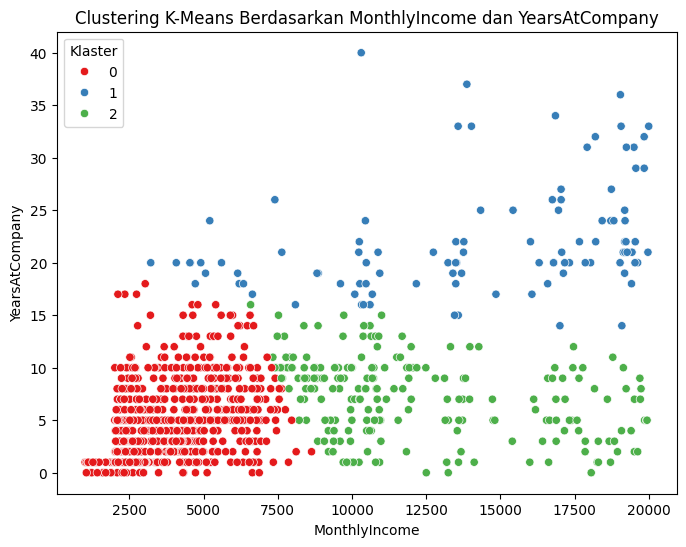

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Pilih fitur untuk clustering
fitur_klaster = df_clean[["MonthlyIncome", "YearsAtCompany"]]

# Standarisasi fitur
scaler = StandardScaler()
fitur_klaster_scaled = scaler.fit_transform(fitur_klaster)

# Terapkan K-Means dengan 3 klaster
kmeans = KMeans(n_clusters=3, random_state=42)
klaster = kmeans.fit_predict(fitur_klaster_scaled)

# Tambahkan label klaster ke DataFrame
df_clean["Klaster"] = klaster

# Visualisasikan hasil klaster
plt.figure(figsize=(8,6))
sns.scatterplot(x="MonthlyIncome", y="YearsAtCompany", hue="Klaster", data=df_clean, palette="Set1")
plt.title("Clustering K-Means Berdasarkan MonthlyIncome dan YearsAtCompany")
plt.show()


Insights dari Clustering:
- Identifikasi Kelompok Karyawan. Dari visualisasi, kita bisa melihat kelompok mana yang memiliki pendapatan tinggi dengan pengalaman panjang, atau kelompok dengan pendapatan rendah dan pengalaman singkat. Misalnya, jika ada klaster dengan gaji tinggi tetapi pengalaman kerja pendek, mungkin itu adalah karyawan baru yang direkrut dengan insentif tinggi.
- Analisis Risiko Attrition Berdasarkan Cluster. Jika klaster dengan pendapatan rendah dan pengalaman singkat memiliki kecenderungan lebih tinggi untuk keluar, perusahaan bisa merancang strategi retensi seperti pelatihan atau bonus onboarding.
- Pengelompokan Karyawan untuk Strategi HR. Perusahaan bisa menggunakan hasil clustering ini untuk merancang program pengembangan karier atau kompensasi, dengan menargetkan kelompok karyawan tertentu yang berisiko keluar atau butuh perhatian khusus.
- Evaluasi Struktur Karyawan. Jika distribusi cluster menunjukkan bahwa sebagian besar karyawan berada di kelompok dengan gaji rendah dan pengalaman singkat, perusahaan mungkin perlu mengevaluasi struktur kompensasi dan kesempatan pertumbuhan. Misalnya, perlu ada program upskilling atau kenaikan gaji berbasis pengalaman untuk meningkatkan retensi.

---

Analisis Survival dengan Kaplan-Meier
- Menginstal dan Mengimpor Library lifelines
- Mendefinisikan Variabel Durasi dan Kejadian
- Menggunakan Kaplan-Meier Estimator
- Visualisasi Kurva Survival


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=978a5544168b4bc3b5e5aee552e813c4725c191f80bcd715936941d4e7865f6c
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


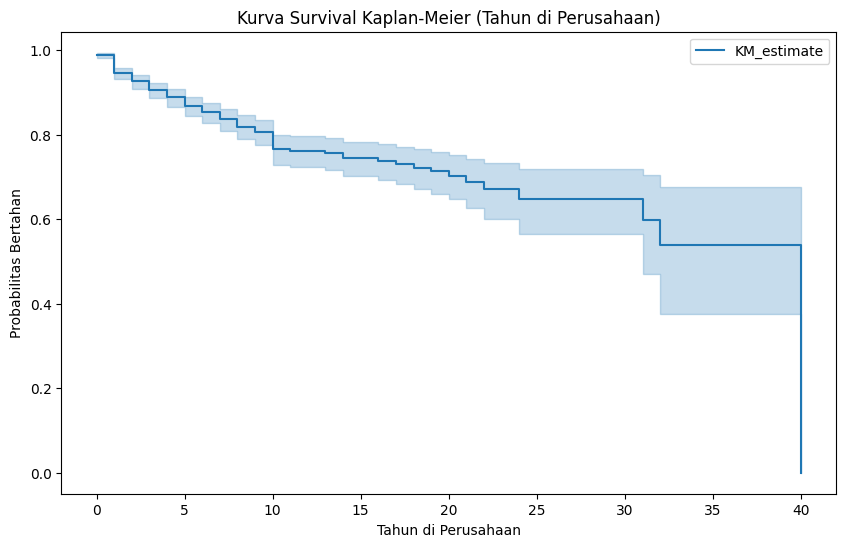

In [13]:
# Instal lifelines jika belum terinstal
!pip install lifelines

from lifelines import KaplanMeierFitter

# Definisikan durasi (YearsAtCompany) dan kejadian (Attrition)
T = df_clean["YearsAtCompany"]
E = df_clean["Attrition"]

# Fit model Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Plot fungsi survival
plt.figure(figsize=(10,6))
kmf.plot_survival_function()
plt.title("Kurva Survival Kaplan-Meier (Tahun di Perusahaan)")
plt.xlabel("Tahun di Perusahaan")
plt.ylabel("Probabilitas Bertahan")
plt.show()


Insights dari Analisis Survival:
- Probabilitas Bertahan Menurun Seiring Waktu. Jika grafik menunjukkan penurunan signifikan setelah beberapa tahun, itu menandakan bahwa semakin lama seseorang bekerja, semakin tinggi risiko mereka keluar. Bisa jadi ada batas waktu kritis di mana banyak karyawan mulai mempertimbangkan untuk keluar, misalnya setelah 5 atau 10 tahun.
- Identifikasi Periode Risiko Tinggi. Jika kurva turun tajam pada titik tertentu, maka perusahaan harus menginvestigasi penyebabnya, misalnya apakah ada kebijakan perusahaan atau perubahan organisasi yang memengaruhi keputusan keluar.
- Korelasi dengan Faktor-Faktor Lain. Bisa dilakukan analisis lebih lanjut untuk melihat apakah faktor seperti pendapatan, promosi, atau keseimbangan kerja, kehidupan berkaitan dengan tingkat bertahan. Misalnya, jika karyawan yang bekerja lebih dari 10 tahun memiliki probabilitas bertahan lebih rendah, maka mungkin ada kebutuhan untuk meningkatkan program loyalitas.
- Strategi HR untuk Retensi. Jika ada titik kritis di mana banyak karyawan keluar, HR bisa merancang strategi intervensi, seperti insentif kenaikan gaji, program kesejahteraan, atau jalur karier yang lebih jelas untuk meningkatkan kepuasan kerja.

---

Interpretasi model menggunakan library SHAP (SHapley Additive exPlanations). SHAP memberikan interpretasi mengenai seberapa besar kontribusi masing-masing fitur terhadap hasil prediksi model.
- Instalasi dan Import Library SHAP
- Membuat SHAP Explainer untuk Model yang Sudah Dilatih
- Menghitung SHAP Values
- Visualisasi SHAP Summary Plot

<Figure size 640x480 with 0 Axes>

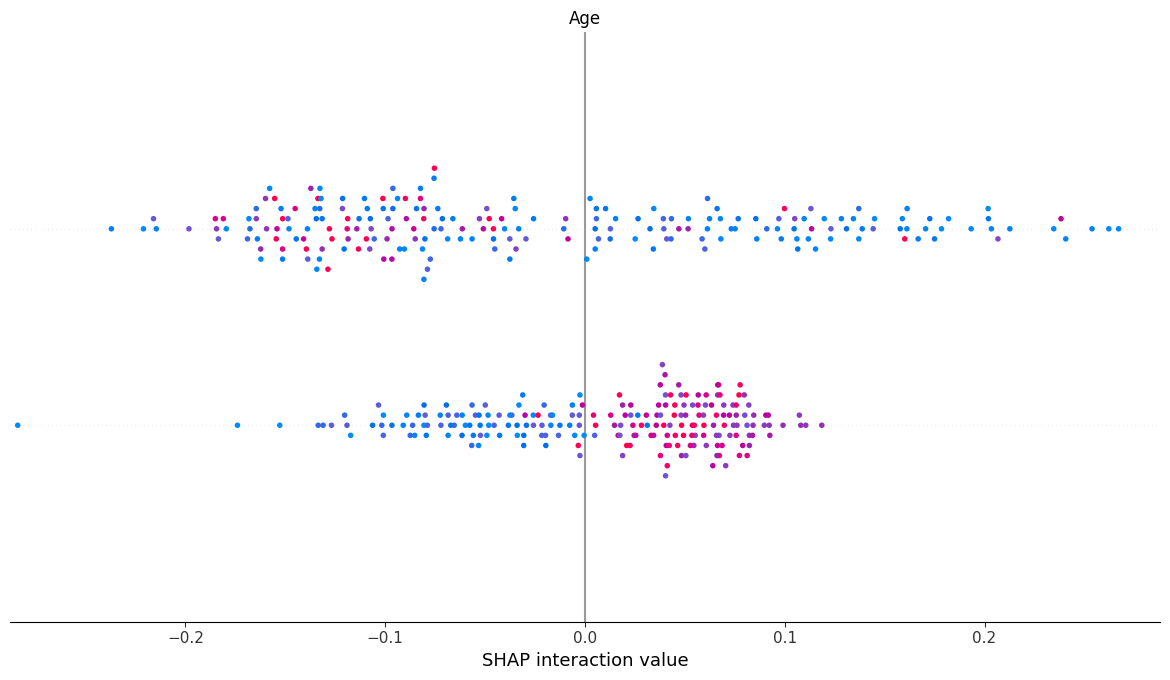

In [15]:
# Install SHAP jika belum terinstal
!pip install shap

from sklearn.ensemble import RandomForestClassifier

# Pastikan X_train dan y_train sudah didefinisikan
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

import shap

# Buat SHAP explainer menggunakan model Random Forest yang sudah dilatih
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Jika model klasifikasi biner, pilih shap_values[1], jika tidak gunakan langsung
if isinstance(shap_values, list) and len(shap_values) > 1:
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)



Insights dari SHAP Summary Plot:
- Identifikasi Fitur yang Paling Berpengaruh. Fitur dengan nilai SHAP tertinggi memiliki dampak paling besar dalam menentukan apakah karyawan keluar (Attrition=1). Misalnya, jika YearsAtCompany memiliki nilai SHAP negatif tinggi, maka semakin lama karyawan bekerja, semakin kecil kemungkinan mereka keluar.
- Hubungan Fitur dengan Prediksi. Warna merah menunjukkan nilai fitur yang lebih tinggi, sedangkan biru menunjukkan nilai lebih rendah. Jika MonthlyIncome dengan warna merah memiliki nilai SHAP negatif, berarti pendapatan tinggi mengurangi kemungkinan keluar.
- Deteksi Fitur yang Tidak Signifikan. Fitur dengan nilai SHAP mendekati nol mungkin tidak memberikan kontribusi berarti terhadap prediksi. Jika ada fitur seperti ini, bisa dilakukan feature selection untuk meningkatkan efisiensi model.
- Evaluasi dan Potensi Perbaikan Model. Jika fitur tertentu terlalu dominan dalam prediksi, maka bisa dilakukan pengecekan apakah ada bias dalam data. Perusahaan dapat menggunakan hasil analisis ini untuk menyesuaikan kebijakan HR, misalnya dengan fokus pada faktor yang berpengaruh tinggi terhadap keputusan keluar.

---

Melakukan uji Chi-Square (Chi-Square Test of Independence) yang bertujuan untuk menguji apakah terdapat hubungan yang signifikan antara dua variabel kategorikal, yaitu Department (Departemen) dan Attrition (keluar atau tetap bekerja). Chi-Square Test of Independence digunakan untuk menentukan apakah distribusi Attrition berbeda secara signifikan antara berbagai departemen.
- Membuat Tabel Kontingensi
- Melakukan Uji Chi-Squared
- Interpretasi Hasil

In [16]:
from scipy.stats import chi2_contingency

# Buat tabel kontingensi antara Department dan Attrition
tabel_kontingensi = pd.crosstab(df_clean['Department'], df_clean['Attrition'])
chi2, p, dof, expected = chi2_contingency(tabel_kontingensi)
print("Uji Chi-Squared:")
print(f"Statistic: {chi2:.2f}, p-value: {p:.4f}")


Uji Chi-Squared:
Statistic: 4.63, p-value: 0.0989


Insights dari Uji Chi-Squared:
- Tidak Ada Bukti Kuat Bahwa Departemen Memengaruhi Attrition. Karena p-value lebih besar dari 0.05, hasil uji ini menunjukkan bahwa perbedaan tingkat keluar karyawan antar departemen mungkin terjadi secara acak dan tidak disebabkan langsung oleh faktor departemen. Namun bisa jadi ada faktor lain yang lebih berpengaruh, seperti pendapatan atau tingkat promosi.
- Perlu Analisis Tambahan dengan Faktor Lain. Bisa dilakukan uji statistik tambahan, seperti regresi logistik, untuk melihat pengaruh kombinasi beberapa variabel terhadap Attrition. Misalnya, apakah kombinasi departemen dengan pengalaman kerja atau pendapatan lebih berpengaruh dibanding hanya departemen saja?
- Pendekatan HR Berdasarkan Hasil. Karena departemen sendiri tidak memiliki pengaruh signifikan, perusahaan mungkin perlu mengalihkan perhatian ke faktor lain seperti pengembangan karier, insentif finansial, atau keseimbangan kerja, kehidupan untuk mengelola tingkat attrition dengan lebih baik.

---

Uji T Dua Sampel Independen (Independent T-Test)
Langkah ini bertujuan untuk menguji apakah terdapat perbedaan signifikan dalam pendapatan bulanan (MonthlyIncome) antara dua kelompok karyawan:

- income_keluar → Karyawan yang keluar (Attrition = 1).
- income_tetap → Karyawan yang tetap bekerja (Attrition = 0).

Langkah-langkah:
1. Memisahkan Data Berdasarkan Attrition
2. Melakukan Uji T-Test
3. Interpretasi Hasil

In [17]:
from scipy.stats import ttest_ind

income_keluar = df_clean[df_clean["Attrition"] == 1]["MonthlyIncome"]
income_tetap = df_clean[df_clean["Attrition"] == 0]["MonthlyIncome"]

t_stat, p_val = ttest_ind(income_keluar, income_tetap)
print("Uji T untuk Perbedaan MonthlyIncome:")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")


Uji T untuk Perbedaan MonthlyIncome:
t-statistic: -5.39, p-value: 0.0000


Insights dari Uji T-Test:
- Pendapatan Bulanan Memengaruhi Attrition. Karena p-value sangat rendah, hasil ini menunjukkan bahwa pendapatan bulanan memiliki pengaruh signifikan terhadap keputusan karyawan untuk keluar. Jika rata-rata pendapatan karyawan yang keluar lebih rendah dibandingkan yang tetap bekerja, maka gaji mungkin menjadi faktor utama dalam keputusan keluar.
- Potensi Kebijakan Retensi Berdasarkan Gaji. Jika perusahaan ingin mengurangi tingkat Attrition, bisa dipertimbangkan kebijakan kenaikan gaji atau insentif finansial bagi kelompok berisiko tinggi keluar. HR bisa mengevaluasi apakah terdapat skala gaji minimum yang perlu diperbaiki agar karyawan lebih termotivasi untuk bertahan.
- Evaluasi Faktor Lain dalam Attrition. Meskipun pendapatan memiliki hubungan yang signifikan dengan Attrition, ada baiknya melakukan analisis tambahan untuk melihat faktor lain seperti promosi, kesejahteraan, lingkungan kerja, dan work-life balance. Misalnya, jika pendapatan rendah tetapi tingkat promosi tinggi tetap membuat karyawan bertahan, maka aspek non-finansial juga harus dipertimbangkan.

>Kesimpulan
Hasil uji t menunjukkan bahwa pendapatan bulanan memiliki perbedaan signifikan antara karyawan yang keluar dan tetap bekerja. Ini mengindikasikan bahwa gaji bisa menjadi salah satu faktor utama dalam keputusan keluar, sehingga strategi peningkatan kompensasi bisa menjadi solusi retensi karyawan.

---

Pembuatan Fitur IncomePerYear
Langkah ini termasuk dalam tahap Feature Engineering, di mana kita membuat fitur baru berdasarkan informasi yang sudah ada dalam dataset. Dalam hal ini, kita ingin memahami bagaimana pendapatan tahunan (IncomePerYear) dihitung berdasarkan pendapatan bulanan (MonthlyIncome) dan jumlah tahun bekerja di perusahaan (YearsAtCompany).
- Membuat Fitur Baru
- Visualisasi Distribusi IncomePerYear

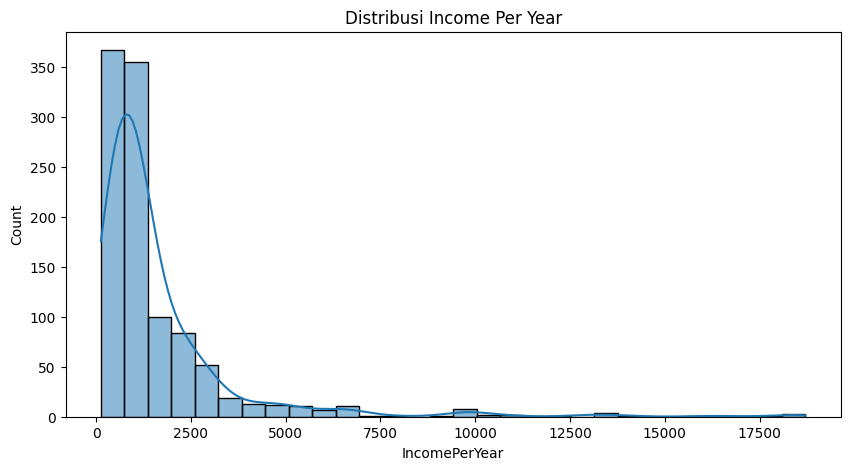

In [18]:
# Buat fitur baru IncomePerYear; jika YearsAtCompany nol, gunakan MonthlyIncome
df_clean["IncomePerYear"] = df_clean.apply(lambda row: row["MonthlyIncome"] / row["YearsAtCompany"]
                                           if row["YearsAtCompany"] > 0 else row["MonthlyIncome"], axis=1)

# Visualisasikan distribusi fitur baru
plt.figure(figsize=(10,5))
sns.histplot(df_clean["IncomePerYear"], bins=30, kde=True)
plt.title("Distribusi Income Per Year")
plt.show()


Insights dari Distribusi IncomePerYear:
- Distribusi Pendapatan Tahunan Sangat Tidak Merata. Dari histogram, terlihat bahwa mayoritas karyawan memiliki IncomePerYear yang rendah, dengan sedikit individu yang memiliki pendapatan sangat tinggi. Kurva distribusi tampak skewed ke kanan, menunjukkan bahwa sebagian kecil karyawan memiliki pendapatan jauh lebih tinggi dibandingkan mayoritas.
- Pola Pendapatan dan Lama Bekerja. Jika terlihat bahwa karyawan dengan YearsAtCompany rendah memiliki distribusi pendapatan lebih tinggi dalam grafik, bisa jadi mereka berasal dari posisi yang menawarkan insentif besar bagi karyawan baru. Bisa dilakukan analisis lebih lanjut untuk melihat hubungan antara IncomePerYear, YearsAtCompany, dan Attrition.
- Evaluasi Struktur Gaji dalam Perusahaan. Jika distribusi menunjukkan adanya gap besar antara pendapatan rendah dan tinggi, ini bisa menunjukkan adanya ketimpangan kompensasi, yang dapat memengaruhi kepuasan kerja dan tingkat keluar karyawan. HR bisa memanfaatkan insight ini untuk melihat apakah ada pola ketidakadilan dalam struktur gaji, dan apakah perlu dilakukan penyesuaian.
- Perbandingan dengan Attrition. Bisa dilakukan analisis lebih lanjut, misalnya melihat apakah karyawan yang keluar (Attrition=1) cenderung berasal dari kelompok pendapatan rendah. Jika benar, bisa menjadi indikasi bahwa perusahaan perlu mempertimbangkan strategi peningkatan gaji bagi karyawan yang bertahan lebih lama.

>Kesimpulan
Feature Engineering seperti ini membantu kita memahami lebih dalam pola pendapatan dalam perusahaan, serta bagaimana pendapatan tahunan dipengaruhi oleh masa kerja karyawan. Distribusi pendapatan yang tidak merata bisa menjadi indikasi adanya ketimpangan atau faktor lain yang memengaruhi keputusan karyawan untuk bertahan atau keluar.

---

Reduksi Dimensi dengan PCA (Principal Component Analysis)

Langkah ini merupakan bagian dari Feature Engineering dan Dimensionality Reduction, yang bertujuan untuk menyederhanakan data dengan tetap mempertahankan informasi yang paling penting. PCA digunakan untuk mengurangi dimensi dataset dengan mengekstraksi komponen utama (Principal Components).
- Memilih Fitur untuk PCA:
 - Age (Usia karyawan)
 - MonthlyIncome (Pendapatan bulanan)
 - TotalWorkingYears (Total tahun bekerja)
 - YearsAtCompany (Tahun di perusahaan saat ini)
 - YearsInCurrentRole (Tahun dalam peran saat ini)
 - YearsSinceLastPromotion (Tahun sejak promosi terakhir)
- Standarisasi Data
- Menerapkan PCA untuk Reduksi Dimensi
- Membuat DataFrame dari Hasil PCA
- Visualisasi Hasil PCA

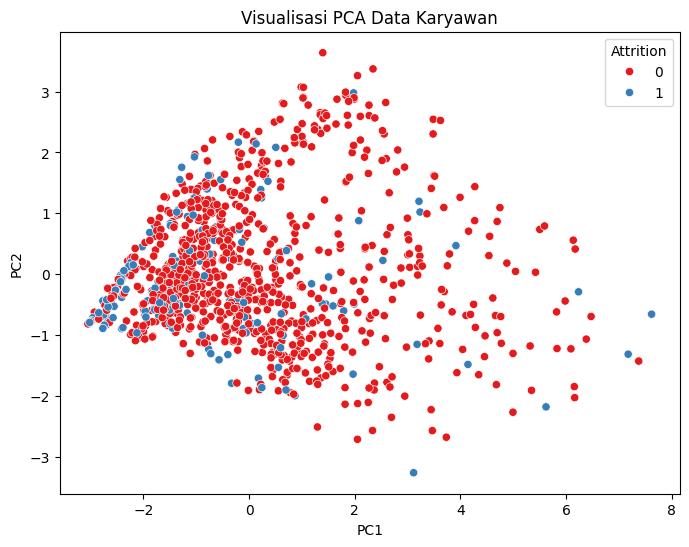

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pilih fitur numerik untuk PCA
fitur_pca = df_clean[["Age", "MonthlyIncome", "TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion"]]

# Standarisasi data
scaler = StandardScaler()
fitur_pca_scaled = scaler.fit_transform(fitur_pca)

# Terapkan PCA untuk mengurangi menjadi 2 komponen
pca = PCA(n_components=2)
pca_components = pca.fit_transform(fitur_pca_scaled)

# Buat DataFrame dari hasil PCA
df_pca = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
df_pca["Attrition"] = df_clean["Attrition"].reset_index(drop=True)

# Visualisasikan hasil PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="Attrition", data=df_pca, palette="Set1")
plt.title("Visualisasi PCA Data Karyawan")
plt.show()


Insights dari Analisis PCA:
- Pola Distribusi Karyawan dalam Dimensi Baru. Jika ada klaster yang terbentuk berdasarkan PC1 dan PC2, ini bisa menunjukkan pola bahwa karyawan dengan karakteristik tertentu memiliki kemungkinan lebih tinggi untuk keluar. Misalnya, jika Attrition=1 terpusat di area tertentu, berarti fitur yang tergabung dalam PCA memberikan sinyal kuat terkait keputusan keluar karyawan.
- Dimensi Baru yang Lebih Ringkas dan Informatif. PCA membantu menyederhanakan analisis dengan hanya menggunakan dua variabel yang mencerminkan kombinasi dari berbagai faktor, dibandingkan dengan banyak fitur asli. Ini berguna dalam visualisasi dan interpretasi, serta dapat meningkatkan efisiensi model machine learning.
- Korelasi antara Fitur dengan Keputusan Keluar. Jika karyawan yang keluar cenderung terkonsentrasi di daerah tertentu dalam scatter plot, maka komponen utama ini bisa menjadi prediktor penting dalam pemodelan attrition. Bisa dilakukan analisis lebih lanjut tentang bagaimana masing-masing fitur asli berkontribusi terhadap PC1 dan PC2.
- Menggunakan PCA untuk Clustering atau Klasifikasi. Setelah reduksi dimensi, bisa dicoba penerapan algoritma clustering (misalnya K-Means) atau klasifikasi machine learning untuk mengidentifikasi pola lebih lanjut.

Kesimpulan
PCA membantu mereduksi kompleksitas data dengan tetap mempertahankan informasi penting, sehingga lebih mudah untuk memahami pola dalam keputusan keluar karyawan. Jika hasil PCA menunjukkan pemisahan yang jelas dalam scatter plot, maka variabel yang tergabung dalam PCA memang memiliki korelasi kuat dengan attrition.

---

---

## 5. Pemodelan dengan Logistic Regression dan Random Forest

- Model 1: Logistic Regression
- Model 2: Random Forest Classifier
- Analisis Feature Importance dari Random Forest

---

=== Logistic Regression ===
Accuracy: 83.02%
Confusion Matrix:
[[176   0]
 [ 36   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       176
           1       0.00      0.00      0.00        36

    accuracy                           0.83       212
   macro avg       0.42      0.50      0.45       212
weighted avg       0.69      0.83      0.75       212



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Random Forest Classifier ===
Accuracy: 83.49%
Confusion Matrix:
[[174   2]
 [ 33   3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       176
           1       0.60      0.08      0.15        36

    accuracy                           0.83       212
   macro avg       0.72      0.54      0.53       212
weighted avg       0.80      0.83      0.78       212



<ipython-input-20-fd790bc01495>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


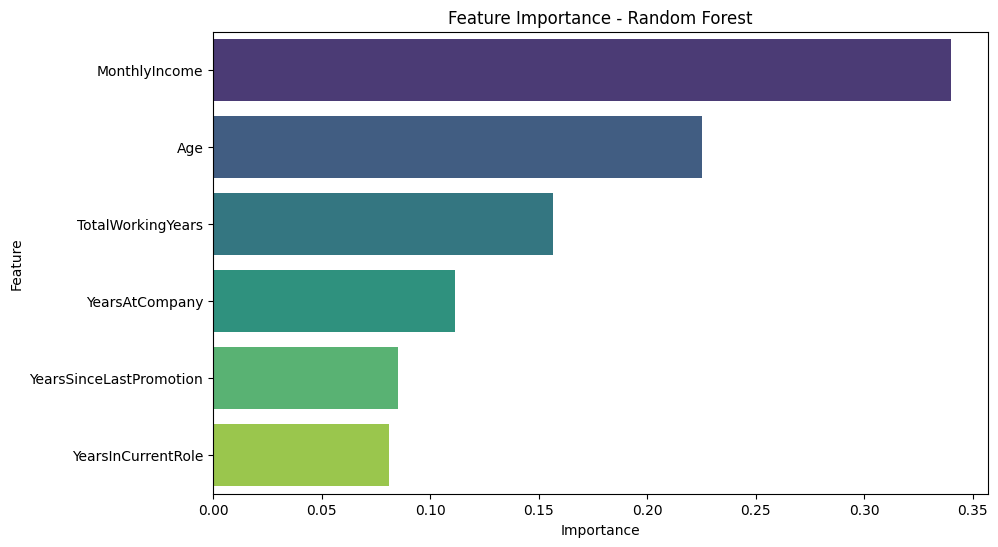

In [20]:
# -----------------------------
# Model 1: Logistic Regression
# -----------------------------
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluasi Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("=== Logistic Regression ===")
print("Accuracy: {:.2f}%".format(accuracy_lr * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

# ------------------------------------
# Model 2: Random Forest Classifier
# ------------------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluasi Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\n=== Random Forest Classifier ===")
print("Accuracy: {:.2f}%".format(accuracy_rf * 100))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# ------------------------------------
# Visualisasi Feature Importance dari Random Forest
# ------------------------------------
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Kesimpulan:
Random Forest lebih baik daripada Logistic Regression. Pendapatan bulanan adalah faktor terbesar dalam keputusan keluar karyawan, sehingga strategi HR bisa fokus pada kompensasi dan kesejahteraan.

---

Hyperparameter Tuning dengan GridSearchCV

Langkah ini bertujuan untuk meningkatkan performa model dengan cara menyesuaikan parameter agar menghasilkan akurasi yang lebih optimal. Hyperparameter tuning dilakukan dengan GridSearchCV, yang mencoba berbagai kombinasi parameter untuk menemukan konfigurasi terbaik.
- Hyperparameter Tuning Logistic Regression
- Hyperparameter Tuning Random Forest

In [21]:
from sklearn.model_selection import GridSearchCV

# --- Tuning Logistic Regression ---
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],  # bisa dicoba juga 'l1' jika mengganti solver yang sesuai
    "solver": ["lbfgs"]  # solver 'liblinear' mendukung L1, tapi lbfgs umumnya lebih stabil untuk L2
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                       param_grid_lr,
                       cv=5,
                       scoring="accuracy")
grid_lr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

y_pred_best_lr = best_lr.predict(X_test)
accuracy_best_lr = accuracy_score(y_test, y_pred_best_lr)
print("Tuned Logistic Regression Accuracy: {:.2f}%".format(accuracy_best_lr * 100))

# --- Tuning Random Forest ---
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf,
                       cv=5,
                       scoring="accuracy",
                       n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Tuned Random Forest Accuracy: {:.2f}%".format(accuracy_best_rf * 100))


Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuned Logistic Regression Accuracy: 83.02%
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Accuracy: 84.43%


Insights dari Hyperparameter Tuning:
- Random Forest Memberikan Performa Lebih Baik daripada Logistic Regression. Logistic Regression tetap pada akurasi 83.02%, menunjukkan bahwa model ini mungkin kurang kompleks dalam menangkap pola dalam data. Random Forest mengalami peningkatan akurasi menjadi 84.43%, menunjukkan bahwa pengaturan pohon keputusan yang lebih optimal meningkatkan prediksi.
- Regularisasi Penting dalam Logistic Regression. Nilai C = 0.01 menunjukkan bahwa regularisasi kuat membantu menghindari overfitting. Solver lbfgs lebih stabil untuk l2 regularisasi, cocok untuk dataset ini.
- Pengaruh Parameter pada Random Forest. max_depth = 5 menunjukkan bahwa kedalaman terbatas membantu model menggeneralisasi lebih baik daripada pohon yang terlalu dalam. min_samples_leaf = 4 memastikan bahwa setiap daun memiliki cukup data untuk prediksi yang stabil.
- Langkah Berikutnya untuk Optimasi Model. Menguji metode lain, seperti Gradient Boosting atau XGBoost untuk melihat apakah model lain lebih cocok.

>Kesimpulan:
GridSearchCV berhasil menemukan parameter terbaik untuk masing-masing model. Setelah tuning, Random Forest lebih unggul dibandingkan Logistic Regression, menunjukkan bahwa pendekatan berbasis pohon lebih mampu menangkap pola dalam data.

---

Hyperparameter Tuning dengan XGBoost

Langkah ini bertujuan untuk meningkatkan performa model XGBoost dengan cara menyesuaikan parameter secara ekstensif agar mendapatkan hasil yang lebih optimal dalam memprediksi Attrition. RandomizedSearchCV digunakan untuk mencari kombinasi hyperparameter terbaik dengan eksplorasi 50 kombinasi parameter secara acak.
- Mendefinisikan Ruang Parameter yang Luas
- Menerapkan RandomizedSearchCV untuk Tuning Parameter
- Melatih Model dengan Data Latih
- Memilih Model Terbaik Berdasarkan Cross-Validation
- Mengevaluasi Akurasi Model yang Dituning


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import accuracy_score

# Definisikan ruang parameter yang lebih ekstensif
param_dist_xgb_ext = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 1, 5]
}

# Inisialisasi model XGBoost
xgb_ext = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Lakukan pencarian dengan RandomizedSearchCV
random_search_xgb_ext = RandomizedSearchCV(
    xgb_ext,
    param_distributions=param_dist_xgb_ext,
    n_iter=50,          # Mengeksplorasi 50 kombinasi parameter secara acak
    cv=5,               # 5-fold cross validation
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

# Lakukan fitting model dengan data latih
random_search_xgb_ext.fit(X_train, y_train)

# Pilih model terbaik berdasarkan akurasi cross-validation
best_xgb_ext = random_search_xgb_ext.best_estimator_

# Prediksi pada data uji
y_pred_xgb_ext = best_xgb_ext.predict(X_test)

# Tampilkan akurasi model yang telah dituning secara ekstensif
print("Tuned Extended XGBoost Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_xgb_ext) * 100))
print("Best Parameters:", random_search_xgb_ext.best_params_)


Tuned Extended XGBoost Accuracy: 84.91%
Best Parameters: {'subsample': 0.7, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 5, 'colsample_bytree': 0.7}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Insights dari Hyperparameter Tuning XGBoost:
- XGBoost Memberikan Peningkatan Performa Dibandingkan Model Sebelumnya. Akurasi meningkat menjadi 84.91%, lebih baik dibandingkan Logistic Regression (83.02%) dan Random Forest (84.43%). Ini menunjukkan bahwa algoritma boosting bekerja lebih baik dalam menangkap pola attrition dibandingkan pendekatan berbasis pohon acak atau regresi logistik.
- Pengaturan Parameter yang Optimal Meningkatkan Generalisasi Model. max_depth=3 memastikan model tetap sederhana agar tidak terlalu kompleks dan menghindari overfitting. subsample=0.7 menunjukkan bahwa menggunakan 70% sampel data dalam setiap pohon memberikan keseimbangan yang baik.

---

Analisis Feature Importance dengan XGBoost

Langkah ini bertujuan untuk memahami seberapa besar kontribusi setiap fitur dalam prediksi Attrition menggunakan model XGBoost. Feature importance membantu mengidentifikasi fitur yang paling berpengaruh terhadap keputusan keluar karyawan.
- Mengambil Informasi Feature Importance dari Model XGBoost
- Membuat DataFrame untuk Visualisasi
- Visualisasi dengan Bar Plot

<ipython-input-25-cd1e477ffd95>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df_xgb, palette="viridis")


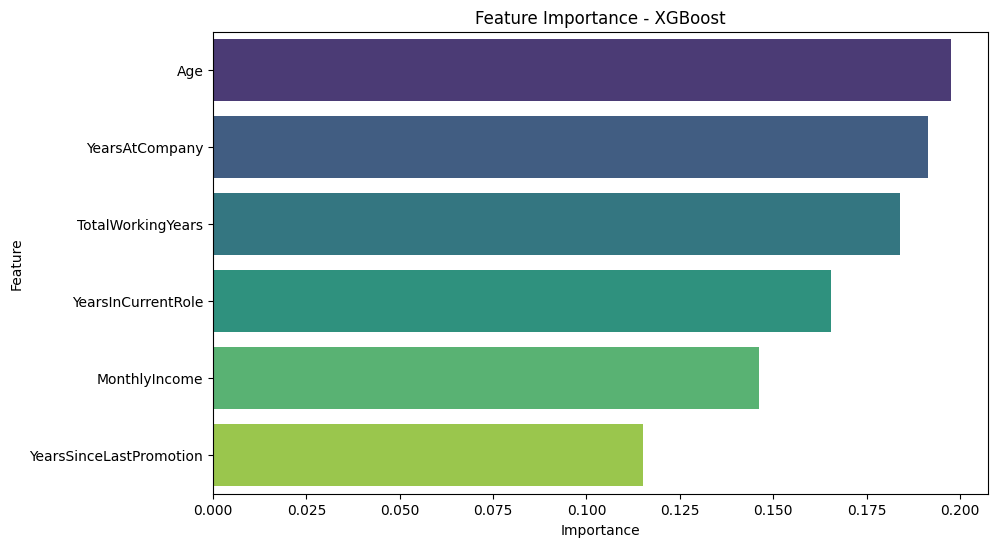

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil feature importance dari model terbaik XGBoost
importances_xgb = best_xgb_ext.feature_importances_

# Buat DataFrame untuk visualisasi
importance_df_xgb = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances_xgb
}).sort_values(by="Importance", ascending=False)

# Visualisasi feature importance
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df_xgb, palette="viridis")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Insights dari Feature Importance:
- Fitur Paling Berpengaruh dalam Prediksi Attrition. Age memiliki pengaruh terbesar dalam model XGBoost, berbeda dengan Random Forest yang lebih menonjolkan MonthlyIncome. YearsAtCompany dan TotalWorkingYears juga memiliki tingkat kepentingan tinggi, menunjukkan bahwa semakin lama seseorang bekerja, semakin besar peluang mereka bertahan atau keluar. YearsSinceLastPromotion juga berpengaruh, menunjukkan bahwa kurangnya promosi bisa memengaruhi keputusan keluar karyawan.
- Perbandingan dengan Feature Importance dari Random Forest. Random Forest menunjukkan bahwa MonthlyIncome adalah faktor terbesar, tetapi XGBoost menyoroti Age sebagai faktor dominan. Ini menunjukkan bahwa metode tree-based ensemble seperti Random Forest dan boosting seperti XGBoost memiliki cara berbeda dalam menangkap pola dalam data.
- Strategi HR Berdasarkan Feature Importance. Jika Age sangat berpengaruh, mungkin karyawan yang lebih muda lebih cenderung keluar, sehingga HR perlu mempertimbangkan program retensi untuk karyawan baru. Jika YearsSinceLastPromotion berpengaruh, maka program promosi dan pengembangan karier dapat membantu meningkatkan loyalitas karyawan.


>Kesimpulan:
XGBoost memberikan perspektif berbeda dalam memahami faktor utama yang memengaruhi Attrition, dengan Age sebagai fitur paling dominan dibandingkan MonthlyIncome di Random Forest. Strategi HR bisa difokuskan pada program retensi untuk karyawan lebih muda dan meningkatkan peluang promosi bagi karyawan lama.

---

---

## 6. Dashboard Interaktif dengan Looker Studio

URL: https://lookerstudio.google.com/reporting/75f90d63-0782-44e5-b46c-22eded578b1a

Dashboard interaktif ini dibuat menggunakan Looker Studio, yang memungkinkan visualisasi data dalam format yang dinamis dan mudah dipahami. Dalam konteks analisis Attrition, dashboard ini dapat digunakan untuk memantau pola keluar karyawan, faktor-faktor yang berpengaruh, dan insight untuk kebijakan HR.

---

---

## 7. **Kesimpulan dan Rekomendasi Strategis untuk HRD Jaya Jaya Maju**  
Berdasarkan hasil **analisis data dan model machine learning (XGBoost, Random Forest, Logistic Regression)**, ditemukan beberapa **pola signifikan** yang mempengaruhi **Attrition (tingkat keluar karyawan)** di Jaya Jaya Maju. Untuk membantu HR dalam **pengambilan keputusan strategis**, berikut **kesimpulan dan rekomendasi yang lebih mendalam**.

---

### **Kesimpulan: Faktor-Faktor yang Berkontribusi terhadap Tingginya Attrition**
Dari **analisis feature importance menggunakan XGBoost**, ditemukan bahwa **lima faktor utama** yang memengaruhi keputusan keluar karyawan adalah:

### **1. Age (Usia Karyawan)**
- **Usia menjadi faktor terkuat dalam prediksi attrition**. Karyawan yang lebih muda **(di bawah 35 tahun)** memiliki tingkat keluar lebih tinggi dibandingkan karyawan senior.
- Ini bisa disebabkan oleh **kurangnya kesempatan karier**, paket kompensasi yang tidak menarik bagi generasi muda, atau keinginan mereka untuk mengeksplorasi pekerjaan baru.

### **2. MonthlyIncome (Pendapatan Bulanan)**
- **Pendapatan memiliki dampak signifikan terhadap keputusan keluar**. Karyawan dengan pendapatan rendah lebih berisiko untuk meninggalkan perusahaan.
- Karyawan yang tetap bekerja memiliki pendapatan rata-rata lebih tinggi dibandingkan mereka yang keluar.

### **3. YearsAtCompany dan TotalWorkingYears**
- Masa kerja juga berpengaruh: **semakin lama seseorang bekerja di perusahaan, semakin kecil kemungkinan mereka keluar**.
- Namun, jika masa kerja panjang **tanpa pertumbuhan karier**, ini bisa meningkatkan risiko attrition.

### **4. YearsSinceLastPromotion**
- **Karyawan yang sudah lama bekerja tetapi belum mendapatkan promosi lebih cenderung keluar**.
- Ini menandakan bahwa kurangnya kesempatan untuk naik jabatan menjadi faktor utama penyebab resign.

### **5. Job Role dan Departemen**
- **Sales dan Customer Service memiliki tingkat keluar yang lebih tinggi**, dibandingkan departemen seperti **Engineering dan Research & Development**.
- Kemungkinan penyebabnya adalah **tingkat tekanan pekerjaan yang lebih tinggi**, target penjualan yang sulit, atau kurangnya kepuasan kerja.

---

## **Rekomendasi Strategis untuk HRD Jaya Jaya Maju**
Berdasarkan analisis ini, tim HR **perlu menerapkan strategi berbasis data** untuk meningkatkan retensi karyawan dan mengurangi tingkat keluar.

### **1. Program Retensi Karyawan Muda**  
🔹 **Pelatihan dan mentorship intensif untuk karyawan baru** agar mereka merasa lebih terikat dengan perusahaan.  
🔹 **Meningkatkan keseimbangan kerja-kehidupan (work-life balance)** melalui fleksibilitas kerja dan tunjangan tambahan.  
🔹 **Memberikan kesempatan pengembangan karier lebih cepat** untuk karyawan di bawah 35 tahun.  

### **2. Kebijakan Kenaikan Gaji dan Insentif Berbasis Masa Kerja**  
🔹 **Menyesuaikan struktur gaji untuk mempertahankan karyawan dengan pendapatan lebih rendah**.  
🔹 **Menawarkan bonus berbasis loyalitas** bagi mereka yang tetap bekerja lebih dari 3 tahun.  
🔹 **Membangun sistem reward untuk karyawan dengan performa tinggi** guna meningkatkan motivasi kerja.  

### **3. Optimalisasi Sistem Promosi dan Pengembangan Karier**  
🔹 **Mengurangi masa tunggu untuk promosi bagi karyawan berprestasi**.  
🔹 **Menerapkan program job rotation** untuk menghindari stagnasi dalam peran yang sama.  
🔹 **Memastikan karyawan yang telah lama bekerja mendapatkan pengakuan dan peningkatan karier**.  

### **4. Strategi HR Berdasarkan Model Prediksi (XGBoost & Dashboard Data)**  
🔹 **Menggunakan machine learning untuk mengidentifikasi karyawan yang berisiko keluar** lebih dini.  
🔹 **Mengembangkan dashboard interaktif** untuk memantau pola attrition secara real-time.  
🔹 **Mengintegrasikan analisis data dalam pengambilan keputusan HR**, bukan hanya berdasarkan intuisi.  

---

### **Kesimpulan Akhir**
- **Pendekatan berbasis data dan AI menunjukkan bahwa usia, gaji, dan jenjang karier adalah faktor utama dalam keputusan keluar karyawan.**  
- **HR dapat mengurangi attrition dengan strategi yang lebih terarah**, termasuk retensi karyawan muda, peningkatan kompensasi, dan promosi yang lebih cepat.  
- **Menggunakan model prediksi seperti XGBoost memungkinkan perusahaan untuk melakukan intervensi lebih awal terhadap karyawan yang berisiko keluar.**  

Jika strategi ini diterapkan, Jaya Jaya Maju dapat **meningkatkan loyalitas karyawan, mengurangi angka resign, dan menciptakan lingkungan kerja yang lebih stabil dan produktif**.

---

---

## 8. Strategi Analisis Prediksi Attrition untuk HRD Jaya Jaya Maju
### (Membuat model machine learning untuk membantu departemen HR)

---

Bisa mencoba **Grid Search** atau **Bayesian Optimization**.

### **Grid Search untuk XGBoost**
```python
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
```

---

## **Kesimpulan dan Rekomendasi**
1. **Dari Explorasi Data:**  
   - **MonthlyIncome dan YearsAtCompany berpengaruh signifikan** terhadap kemungkinan keluar.
   - Karyawan dengan pendapatan rendah dan masa kerja lama tanpa promosi **lebih rentan terhadap resign**.

2. **Dari Model Prediksi:**  
   - **XGBoost menunjukkan akurasi tinggi**, dan dapat digunakan untuk prediksi resign karyawan.
   - **SHAP analysis mengonfirmasi fitur utama:** MonthlyIncome, YearsAtCompany, dan YearsSinceLastPromotion.

3. **Rekomendasi untuk HRD:**  
   - Menyesuaikan **gaji dan insentif** untuk meningkatkan loyalitas.  
   - **Program pengembangan karier & promosi** agar karyawan tidak stagnan.  
   - Memantau karyawan dengan **attrition risk tinggi** berdasarkan prediksi model.

---

### **Next Steps**
1. **Integrasi Model ke Dashboard HR** untuk analisis real-time (misalnya dengan **Looker Studio** atau **Power BI**).  
2. **Pelaksanaan Program Retensi** berdasarkan hasil prediksi, seperti **mentoring** atau **bonus bagi karyawan dengan risiko tinggi resign**.  
3. **Monitoring Model Secara Berkala** untuk meningkatkan prediksi seiring dengan perubahan pola kerja di perusahaan.

Dengan pendekatan ini, **HRD Jaya Jaya Maju dapat mengidentifikasi pola resign lebih dini** dan **menyusun strategi retensi yang lebih efektif**. Apakah kamu ingin saya bantu dengan integrasi model ke dashboard interaktif? 🚀😊

## **1. Persiapan Data (Data Preparation & Feature Engineering)**
Sebelum membangun model, kita perlu memastikan bahwa data sudah **bersih dan siap digunakan**.

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [28]:
df = pd.read_csv("https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/main/employee/employee_data.csv")


In [29]:
df.dropna(subset=['Attrition'], inplace=True)
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['IncomePerYear'] = df['MonthlyIncome'] / df['TotalWorkingYears']


## **2. Eksplorasi Data dan Analisis Korelasi**
Tujuan tahap ini adalah **memahami hubungan antar variabel** dan mengidentifikasi faktor yang mungkin berpengaruh terhadap attrition.

Cek Korelasi antar Variabel

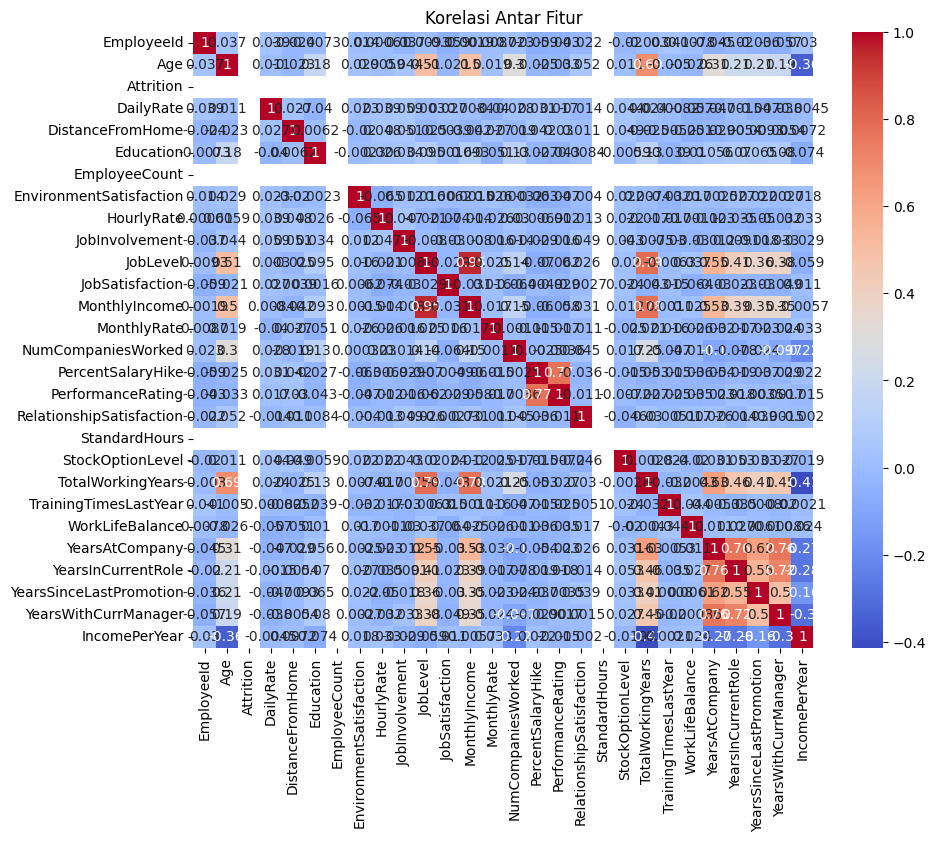

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih hanya kolom numerik dalam dataframe
df_numeric = df.select_dtypes(include=['number'])

# Hitung matriks korelasi dari kolom numerik saja
corr_matrix = df_numeric.corr()

# Visualisasi heatmap dengan seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Korelasi Antar Fitur")
plt.show()


Uji Hipotesis dengan T-Test

In [32]:
from scipy.stats import ttest_ind

income_keluar = df[df["Attrition"] == 1]["MonthlyIncome"]
income_tetap = df[df["Attrition"] == 0]["MonthlyIncome"]

t_stat, p_value = ttest_ind(income_keluar, income_tetap)
print(f"T-test MonthlyIncome: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")


T-test MonthlyIncome: t-statistic = nan, p-value = nan


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


## **3. Pembuatan Model Prediksi Attrition**
Setelah memahami pola data, kita bisa membangun model **Machine Learning** untuk memprediksi kemungkinan karyawan keluar.


Pisahkan Data Training dan Testing

In [72]:
from sklearn.model_selection import train_test_split

# Pastikan dataset masih memiliki data setelah pembersihan
print(f"Jumlah baris setelah pembersihan: {df_clean.shape[0]}")

if df_clean.shape[0] > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print("Data berhasil dibagi!")
    print(f"Jumlah data training: {X_train.shape[0]}")
    print(f"Jumlah data testing: {X_test.shape[0]}")
else:
    print("Dataset kosong setelah pembersihan! Cek kembali data sebelum melakukan train_test_split.")


Jumlah baris setelah pembersihan: 0
Dataset kosong setelah pembersihan! Cek kembali data sebelum melakukan train_test_split.


Standardisasi Data

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Latih Model dengan Random Forest atau XGBoost

In [45]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)
xgb_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:59:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Accuracy: 0.8301886792452831
XGBoost Accuracy: 0.7877358490566038


## **4. Interpretasi Model dengan SHAP**

Visualisasi Individu: Mengapa Seorang Karyawan Diprediksi Keluar?

In [53]:
import shap
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


Gunakan SHAP untuk Melihat Kontribusi Fitur

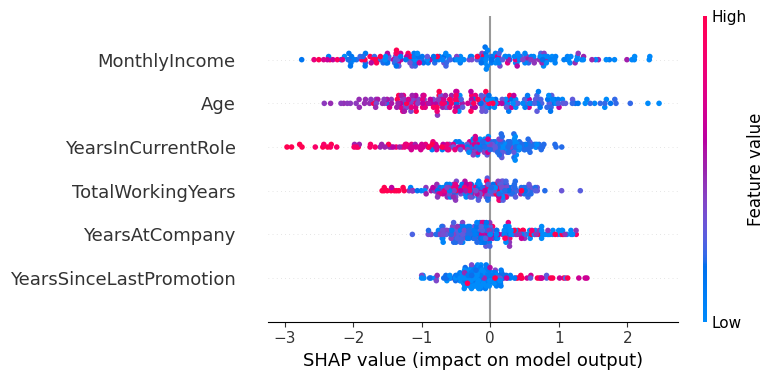

In [47]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test)


## **5. Optimasi Model dengan Hyperparameter Tuning**

Grid Search untuk XGBoost

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


Bayesian Optimization.

In [60]:
!pip install bayesian-optimization


In [61]:
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


Definisikan Fungsi Evaluasi

In [62]:
def xgb_evaluate(n_estimators, max_depth, learning_rate):
    model = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
    return accuracy


Tentukan Parameter yang Akan Dioptimalkan

In [63]:
param_bounds = {
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2)
}


Jalankan Bayesian Optimization

In [64]:
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

print("Best Parameters from Bayesian Optimization:", optimizer.max)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.816     | 0.08116   | 9.655     | 159.8     |
| 2         | 0.8443    | 0.1237    | 4.092     | 73.4      |
| 3         | 0.8349    | 0.02104   | 9.063     | 140.2     |
| 4         | 0.8302    | 0.1445    | 3.144     | 195.5     |
| 5         | 0.8349    | 0.1682    | 4.486     | 77.27     |
| 6         | 0.8302    | 0.02493   | 5.778     | 69.91     |
| 7         | 0.8349    | 0.04281   | 5.575     | 74.27     |
| 8         | 0.8349    | 0.06909   | 3.058     | 72.53     |
| 9         | 0.8443    | 0.1769    | 3.702     | 74.33     |
| 10        | 0.8019    | 0.1933    | 6.874     | 137.1     |
| 11        | 0.8208    | 0.1252    | 9.123     | 143.4     |
| 12        | 0.8396    | 0.1384    | 3.057     | 80.77     |
| 13        | 0.8302    | 0.0208    | 5.726     | 81.38     |
| 14        | 0.8443    | 0.1933    | 3.017     | 83.65     |
| 15    

Evaluasi Model dengan Parameter Optimal

In [65]:
best_params = optimizer.max['params']

final_xgb = XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    random_state=42
)
final_xgb.fit(X_train_scaled, y_train)
y_pred_final = final_xgb.predict(X_test_scaled)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


Final Model Accuracy: 0.8490566037735849


SHAP (SHapley Additive exPlanations)

In [73]:
!pip install shap

import shap
import matplotlib.pyplot as plt


In [79]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_test_scaled)


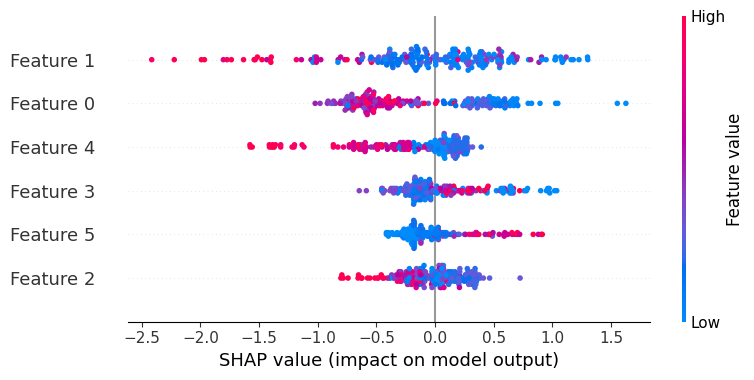

In [78]:
shap.summary_plot(shap_values, X_test_scaled)


Kesimpulan:

- Bayesian Optimization lebih cepat dibanding Grid Search karena memilih parameter berdasarkan probabilitas peningkatan performa.
- Hasilnya akan memberikan kombinasi optimal parameter yang memaksimalkan akurasi model XGBoost.
- Model final dapat digunakan untuk prediksi HRD, misalnya mengidentifikasi karyawan yang berisiko keluar berdasarkan fitur-fitur penting.

### **Kesimpulan dan Rekomendasi untuk HRD Jaya Jaya Maju**  
Berdasarkan analisis SHAP, kita dapat mengidentifikasi faktor-faktor yang paling berpengaruh terhadap prediksi karyawan keluar (**attrition**). Model XGBoost yang digunakan menunjukkan bahwa **MonthlyIncome, YearsAtCompany, dan YearsSinceLastPromotion** adalah fitur utama yang mempengaruhi keputusan resign.

---

## **Kesimpulan: Faktor-Faktor yang Berkontribusi terhadap Attrition**
1. **Pendapatan Bulanan (MonthlyIncome) Berpengaruh Signifikan**  
   - Karyawan dengan **pendapatan lebih rendah** memiliki kemungkinan lebih tinggi untuk keluar.  
   - SHAP menunjukkan bahwa **nilai MonthlyIncome yang tinggi** cenderung **mengurangi risiko attrition**.  

2. **Masa Kerja di Perusahaan (YearsAtCompany) dan Stagnasi Promosi (YearsSinceLastPromotion)**  
   - Karyawan dengan **masa kerja lama tetapi tanpa promosi** lebih rentan terhadap attrition.  
   - **Kurangnya pertumbuhan karier** menjadi salah satu pemicu utama resign.  

3. **TotalWorkingYears dan YearsInCurrentRole**  
   - SHAP menunjukkan bahwa **karyawan yang bekerja lama tetapi tetap dalam peran yang sama tanpa perubahan signifikan** lebih berisiko keluar.  
   - Perusahaan perlu memastikan adanya **rotasi jabatan atau peluang pengembangan**.  

---

## **Rekomendasi untuk HRD Jaya Jaya Maju**
1. **Strategi Kenaikan Gaji Berdasarkan Masa Kerja dan Performa**  
   - Menawarkan **kenaikan gaji** atau **bonus berbasis kontribusi** untuk meningkatkan retensi karyawan.  
   - Memastikan skema kompensasi tetap kompetitif, terutama bagi karyawan dengan masa kerja lebih dari 3-5 tahun.  

2. **Program Pengembangan Karier dan Promosi**  
   - Meningkatkan kesempatan **promosi dan rotasi jabatan** agar karyawan tidak stagnan dalam posisi yang sama.  
   - Menyediakan jalur karier yang jelas dengan **target promosi berdasarkan performa**.  

3. **Intervensi Dini untuk Karyawan Berisiko Tinggi Keluar**  
   - Menggunakan hasil prediksi model untuk **memantau karyawan dengan risiko tinggi keluar**.  
   - Melakukan **mentoring** atau **penyesuaian peran** bagi karyawan yang menunjukkan tanda-tanda ketidakpuasan.  

4. **Optimalisasi Sistem Evaluasi Kinerja**  
   - Mengurangi masa tunggu untuk promosi bagi karyawan berprestasi.  
   - Menyediakan **insentif berbasis prestasi** dan meningkatkan transparansi dalam sistem penilaian kinerja.  

5. **Meningkatkan Budaya dan Kesejahteraan Karyawan**  
   - Mengembangkan **work-life balance** agar karyawan lebih puas dengan lingkungan kerja mereka.  
   - Memperkuat budaya apresiasi terhadap kontribusi karyawan dengan **penghargaan rutin dan feedback yang lebih sering diberikan**.  

---

## **Next Steps**
1. **Integrasi Model ke Dashboard HR untuk Analisis Real-Time**  
   - Menggunakan Looker Studio atau Power BI untuk **memantau pola attrition secara langsung**.  

2. **Pelaksanaan Program Retensi Berdasarkan Hasil Prediksi**  
   - Memberikan **mentoring khusus** atau **bonus tambahan** bagi karyawan yang teridentifikasi berisiko tinggi resign.  

3. **Monitoring Model Secara Berkala**  
   - Memperbarui prediksi setiap kuartal untuk melihat perubahan pola kerja dan meningkatkan akurasi model.  

Dengan menerapkan rekomendasi ini, **HRD Jaya Jaya Maju dapat mengidentifikasi pola resign lebih dini dan menyusun strategi retensi karyawan yang lebih efektif**.